# Sprint0 - Lightweight model fine-tuning on a random subset of data

This sprint consists of pre-training a lightweight model.

The model is small enough that it can be trained on a macbook. Ensuring that you can train this model will pave the way for the next couple sprints.


### 1. Pip install necessary requirements


In [6]:
!pip install --upgrade pip
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install pandas numpy pyarrow
!pip install transformers datasets accelerate matplotlib



Looking in indexes: https://download.pytorch.org/whl/cpu


### 2. Load a pre-trained model & tokenizer


In [62]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, DataCollatorWithPadding

# load the gpt-2 model and respective tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_name)

# Move to MPS (if your computer is m1 macbook like mine) or CPU
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(device)
model.to(device)

mps


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

### 3. Load a subset of Common Crawl Data


In [65]:
from datasets import load_dataset, Dataset

# load small sample of common crawl dataset
dataset = load_dataset(
    "allenai/c4", "en", split="train", streaming=True, trust_remote_code=True
)
small_dataset = dataset.shuffle(seed=42, buffer_size=10_000).take(10_000)
# small_dataset = dataset.train_test_split(test_size=0.1)

print(small_dataset)

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

IterableDataset({
    features: ['text', 'timestamp', 'url'],
    num_shards: 1024
})


### 4. Fine-Tuning


In [66]:
def tokenize_func(dataset, tokenizer):
    """Tokenizer function for streamed dataset"""
    for example in dataset:
        tokenized = tokenizer(
            example["text"], truncation=True, padding="max_length", max_length=512
        )
        tokenized["labels"] = tokenized["input_ids"].copy()
        yield tokenized


# tokenized_dataset = small_dataset.map(tokenize_func, batched=True).with_format("torch")
tokenized_dataset = Dataset.from_generator(
    lambda: tokenize_func(small_dataset, tokenizer)
)

print(tokenized_dataset)

model.resize_token_embeddings(len(tokenizer))
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 10000
})


In [68]:
from transformers import TrainingArguments, Trainer

# Define training arguments
training_args = TrainingArguments(
    output_dir="./gpt2-finetuned",
    eval_strategy="no",
    save_strategy="epoch",
    per_device_train_batch_size=1,
    max_steps=2000,
    learning_rate=5e-5,
    logging_dir="./logs",
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
)

trainer.train()

Step,Training Loss
500,1.926600
1000,1.926100
1500,1.972900
2000,1.906600


TrainOutput(global_step=2000, training_loss=1.933043487548828, metrics={'train_runtime': 919.1398, 'train_samples_per_second': 2.176, 'train_steps_per_second': 2.176, 'total_flos': 522584064000000.0, 'train_loss': 1.933043487548828, 'epoch': 0.2})

### 5. Plot Auto-Regressive Loss vs Tokens


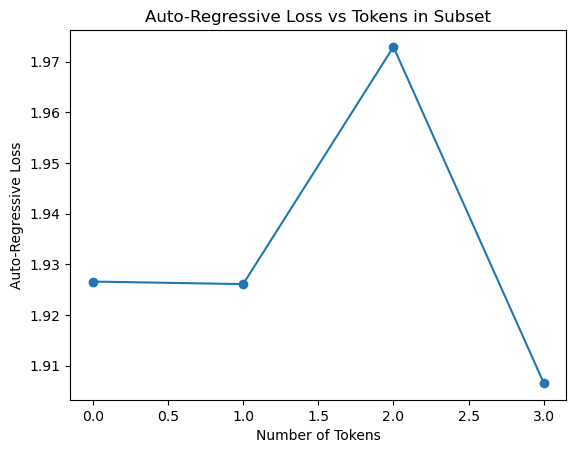

In [69]:
import matplotlib.pyplot as plt

# Assuming 'trainer.state.log_history' has loss values
losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]
steps = list(range(len(losses)))

plt.plot(steps, losses, marker="o")
plt.xlabel("Number of Tokens")
plt.ylabel("Auto-Regressive Loss")
plt.title("Auto-Regressive Loss vs Tokens in Subset")
plt.show()